In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
#Import dependencies
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
#Pass SQLite file through engine
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
#Reflect existing database into new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
#View classes found by automap
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [42]:
#enter start and end date of vacation
start_date = '2016-11-24'
end_date = '2016-11-30'

In [10]:
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurement', 'station']

In [11]:
measurement=Base.classes.measurement
station=Base.classes.station

In [12]:
inspector = inspect(engine)

In [13]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [14]:
col = inspector.get_columns('station')
for c in col:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [15]:
#Design a query to retrieve the last 12 months of precipitation data and plot the results

#Query most recent date in db
recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
print(recent_date)


('2017-08-23',)


In [16]:
#Calculate one year from last date in db
past_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(past_year)

2016-08-23


In [17]:
#Query dates and prcp values within recent year
output = session.query(measurement.date, measurement.prcp).filter(measurement.date>=past_year).all()
print(output)

[('2016-08-23', 0.0), ('2016-08-24', 0.08), ('2016-08-25', 0.08), ('2016-08-26', 0.0), ('2016-08-27', 0.0), ('2016-08-28', 0.01), ('2016-08-29', 0.0), ('2016-08-30', 0.0), ('2016-08-31', 0.13), ('2016-09-01', 0.0), ('2016-09-02', 0.0), ('2016-09-03', 0.0), ('2016-09-04', 0.03), ('2016-09-05', None), ('2016-09-06', None), ('2016-09-07', 0.05), ('2016-09-08', 0.0), ('2016-09-09', 0.03), ('2016-09-10', 0.0), ('2016-09-11', 0.05), ('2016-09-12', 0.0), ('2016-09-13', 0.02), ('2016-09-14', 1.32), ('2016-09-15', 0.42), ('2016-09-16', 0.06), ('2016-09-17', 0.05), ('2016-09-18', 0.0), ('2016-09-19', 0.0), ('2016-09-20', 0.0), ('2016-09-21', 0.0), ('2016-09-22', 0.02), ('2016-09-23', 0.0), ('2016-09-24', 0.0), ('2016-09-25', 0.0), ('2016-09-26', 0.06), ('2016-09-27', 0.02), ('2016-09-28', 0.0), ('2016-09-29', 0.0), ('2016-09-30', 0.0), ('2016-10-01', 0.0), ('2016-10-02', 0.0), ('2016-10-03', 0.0), ('2016-10-04', 0.0), ('2016-10-05', 0.0), ('2016-10-06', 0.0), ('2016-10-07', 0.0), ('2016-10-08', 

In [18]:
# Save query results as Pandas df and set index to the date column
df = pd.DataFrame(output, columns=['date','precipitation']).set_index('date')


In [19]:
#Drop nulls from db
df = df.dropna()


In [20]:
# Sort the dataframe by date
df = df.sort_values('date',ascending=True)
df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15


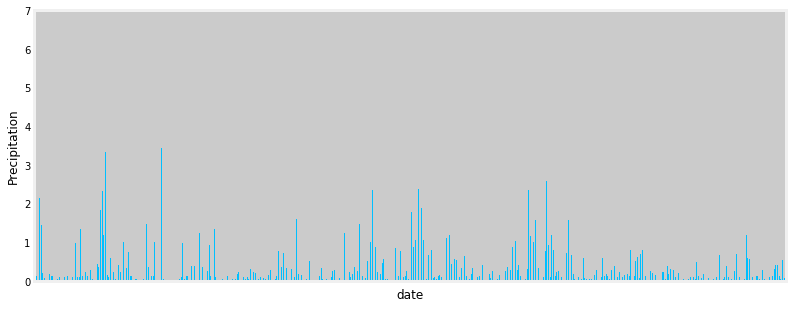

In [146]:
#Pandas Matplotlib to plot the data

df_prcp_bydate = df[df['precipitation']>.01]
fig, ax = plt.subplots(figsize=(12,5))
df_prcp_bydate['precipitation'].plot(kind='bar', ax=ax, color='deepskyblue')
ax.set_xticklabels('')
ax.set_ylabel('Precipitation')
fig.savefig("Images/Precipitation.png")

![precipitation](Images/precipitation.png)

In [22]:
# Use Pandas to calculate summary stats for precipitation data
df_bydate.describe()

,precipitation
count,1047.000000
mean,0.341242
std,0.595740
min,0.020000
25%,0.050000
50%,0.120000
75%,0.350000
max,6.700000


![describe](Images/describe.png)

In [23]:
#Query how many stations are available in dataset?
session.query(station.name).count()

9

In [24]:
# What are the most active stations?
session.query(station.id, station.name, station.latitude, station.longitude, station.elevation, func.count(measurement.id)).\
            filter(measurement.id == station.id).group_by(station.id).\
            order_by(func.count(measurement.id).desc()).first()


(1, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 1)

In [25]:
#List stations and counts in descending order.
session.query(station.name ,func.count(station.name)).group_by(station.name).\
            order_by(func.count(station.name).desc()).all()

[('HONOLULU OBSERVATORY 702.2, HI US', 1),
 ('KANEOHE 838.1, HI US', 1),
 ('KUALOA RANCH HEADQUARTERS 886.9, HI US', 1),
 ('MANOA LYON ARBO 785.2, HI US', 1),
 ('PEARL CITY, HI US', 1),
 ('UPPER WAHIAWA 874.3, HI US', 1),
 ('WAIHEE 837.5, HI US', 1),
 ('WAIKIKI 717.2, HI US', 1),
 ('WAIMANALO EXPERIMENTAL FARM, HI US', 1)]

In [26]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?


In [105]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# query to find tobs for most active station
tobs_results = session.query(measurement.tobs).filter(measurement.date>=past_year).\
                        filter(measurement.id == '1').all()


In [106]:
# importing query results to df
df_tobs = pd.DataFrame(tobs_results, columns=['Temperature'])
df_tobs.describe()

,Temperature
count,0
unique,0


In [137]:
#Plot histogram
# bins=[]
# fig, ax = plt.subplots(figsize=(15,8))
# df_tobs.hist(bins=12, ax=ax, color='c', xlabelsize=12, ylabelsize=12, label='tobs')
# ax.set_title('')
# ax.legend()
# plt.rc('legend', fontsize=25)
# ax.set_ylabel('Frequency',fontsize=20)
# ax.set_ylim(top=70)
# fig.savefig("Images/tobs.png")

![precipitation](Images/station-histogram.png)

In [112]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    
    all = [measurement.date, func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]

    return session.query(*all).group_by(measurement.date).filter(func.strftime("%Y-%m-%d", measurement.date) >=start_date).\
    filter(func.strftime("%Y-%m-%d", measurement.date) <=end_date).all()    
    


In [135]:
# Use your previous function `calc_temps` to calculate tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

trip_temps = calc_temps(start_date, end_date)
df_triptemps = pd.DataFrame(trip_temps, columns=['date', 'TMIN', 'TAVG', 'TMAX'])
df_triptemps = df_triptemps.set_index('date', drop=True)
df_triptemps

,TMIN,TAVG,TMAX
date,,,
2016-11-24,69.0,73.600000,75.0
2016-11-25,69.0,74.000000,76.0
2016-11-26,70.0,75.000000,78.0
2016-11-27,69.0,74.500000,78.0
2016-11-28,71.0,75.000000,77.0
2016-11-29,67.0,72.428571,76.0
2016-11-30,72.0,74.428571,76.0


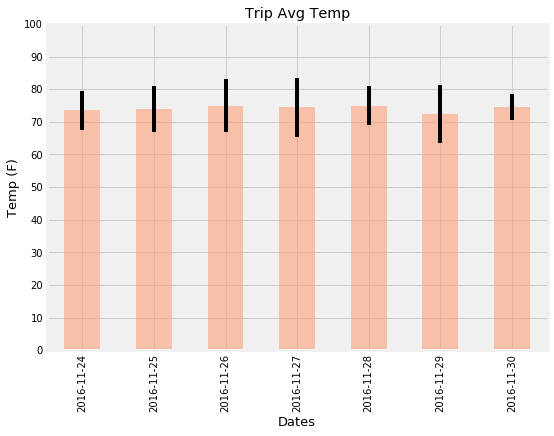

In [143]:
# Results plotted as a bar chart. Avg temperature = bar height, yerr = high and low temps

yerr = df_triptemps['TMAX'] - df_triptemps['TMIN']

fig, ax = plt.subplots(figsize=(8,6))
df_triptemps['TAVG'].plot(kind='bar',color='lightsalmon',alpha=.6, yerr=yerr, ax=ax)
plt.yticks(range(0, 110, 10))
ax.set_ylabel('Temp (F)', fontsize=13)
ax.set_xlabel('Dates', fontsize=13)
ax.set_title('Trip Avg Temp')


fig.savefig("Images/AvgTemp.png")

In [131]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
